In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.constraints import max_norm
import datetime
from PIL import Image

In [2]:
import os
import kaggle

dataset_folder = './dataset/Animals-10'
if not os.path.exists(dataset_folder):
    kaggle.api.dataset_download_files('viratkothari/animal10', path='./dataset', unzip=True)


In [3]:
os.listdir('./dataset/Animals-10')

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [4]:
classes_animal = {'dog': 'dog',
 'butterfly': 'butterfly',
 'sheep': 'sheep',
 'horse': 'horse',
 'spider': 'spider',
 'elephant': 'elephant',
 'chicken': 'chicken',
 'cow': 'cow',
 'cat': 'cat',
 'squirrel': 'squirrel'}

for key, value in classes_animal.items():
    source_path = f"D:/SELF/DATA/data-portofolio/image-classification/dataset/Animals-10/{value}"
    print(f"There are {len(os.listdir(source_path))} images of {value}")

There are 4863 images of dog
There are 2112 images of butterfly
There are 1820 images of sheep
There are 2623 images of horse
There are 4821 images of spider
There are 1446 images of elephant
There are 3098 images of chicken
There are 1866 images of cow
There are 1668 images of cat
There are 1862 images of squirrel


In [5]:
# Specify the path of the dataset folder
dataset_folder = './dataset'

# Create the data folder inside the dataset folder
data_folder = os.path.join(dataset_folder, 'data')
os.makedirs(data_folder, exist_ok=True)


In [7]:
import os
import shutil

# Specify the source and destination folders
source_folder = './dataset/Animals-10'
destination_folder = './dataset/data'

# List all animal folders
animal_folders = ['dog', 'horse', 'chicken']

# Copy all files from each animal folder to the data folder with separate folders
for animal_folder in animal_folders:
    animal_folder_path = os.path.join(source_folder, animal_folder)
    if os.path.isdir(animal_folder_path):
        destination_animal_folder = os.path.join(destination_folder, animal_folder)
        os.makedirs(destination_animal_folder, exist_ok=True)
        files = os.listdir(animal_folder_path)
        for file in files:
            source_file = os.path.join(animal_folder_path, file)
            destination_file = os.path.join(destination_animal_folder, file)
            shutil.copy(source_file, destination_file)


In [8]:
data_animal = {
 'dog': 'dog',
 'horse': 'horse',
 'chicken': 'chicken'}

for key, value in data_animal.items():
    source_path = f"D:/SELF/DATA/data-portofolio/image-classification/dataset/data/{value}"
    print(f"There are {len(os.listdir(source_path))} images of {value}")

There are 4863 images of dog
There are 2623 images of horse
There are 3098 images of chicken


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR="D:/SELF/DATA/data-portofolio/image-classification/dataset/data/"
VALIDATION_DIR="D:/SELF/DATA/data-portofolio/image-classification/dataset/data/"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

train_generator= train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

num_train_data = train_generator.samples
print("Train dataset:", num_train_data)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    class_mode='categorical',
    subset='validation')

num_val_data = validation_generator.samples
print("Validation dataset:", num_val_data)

Found 8469 images belonging to 3 classes.
Train dataset: 8469
Found 2115 images belonging to 3 classes.
Validation dataset: 2115


In [37]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : chicken
1 : dog
2 : horse


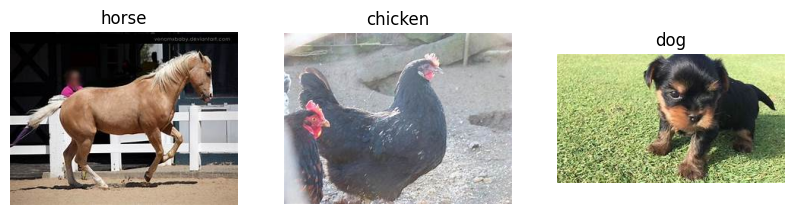

In [38]:
import random

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

# Get a random sample of 3 classes
random_classes = random.sample(list(labels.values()), 3)

for i, value in enumerate(random_classes):
    # Get a random image from the class folder
    image_files = os.listdir(os.path.join(TRAINING_DIR, value))
    random_image = random.choice(image_files)
    image_path = os.path.join(TRAINING_DIR, value, random_image)
    
    # Load and plot the image
    image = plt.imread(image_path)
    ax[i].imshow(image)
    ax[i].set_title(value)
    ax[i].axis('off')

# Show the plot
plt.show()


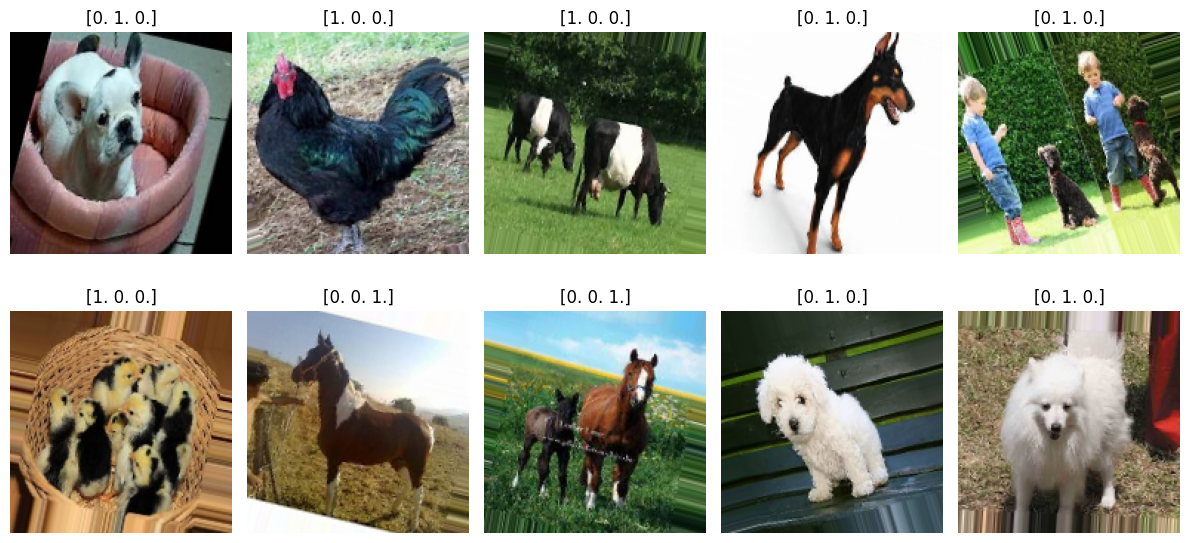

In [39]:
import matplotlib.pyplot as plt

# Get a batch of augmented images and labels
images, labels = next(train_generator)

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),    
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92)):
      print("\nAkurasi dan Val Akurasi telah sesuai tarhet")
      self.model.stop_training = True
callbacks_stop = myCallback()

In [43]:
result = model.fit(train_generator,
                       epochs = 100,
                       validation_data=(validation_generator),
                       callbacks=[callbacks_stop],
                       batch_size=128,
                       verbose=1)

Epoch 1/100
265/265 [==============================] - 44s 165ms/step - loss: 0.9958 - accuracy: 0.5112 - val_loss: 0.8578 - val_accuracy: 0.6392
Epoch 2/100
265/265 [==============================] - 42s 159ms/step - loss: 0.7727 - accuracy: 0.6728 - val_loss: 0.6846 - val_accuracy: 0.7281
Epoch 3/100
265/265 [==============================] - 39s 147ms/step - loss: 0.6381 - accuracy: 0.7452 - val_loss: 0.6092 - val_accuracy: 0.7598
Epoch 4/100
265/265 [==============================] - 39s 148ms/step - loss: 0.5830 - accuracy: 0.7677 - val_loss: 0.5574 - val_accuracy: 0.7768
Epoch 5/100
265/265 [==============================] - 39s 146ms/step - loss: 0.5370 - accuracy: 0.7864 - val_loss: 0.5244 - val_accuracy: 0.8005
Epoch 6/100
265/265 [==============================] - 40s 149ms/step - loss: 0.4968 - accuracy: 0.8111 - val_loss: 0.5469 - val_accuracy: 0.7783
Epoch 7/100
265/265 [==============================] - 39s 146ms/step - loss: 0.4728 - accuracy: 0.8111 - val_loss: 0.5255 -

KeyboardInterrupt: 

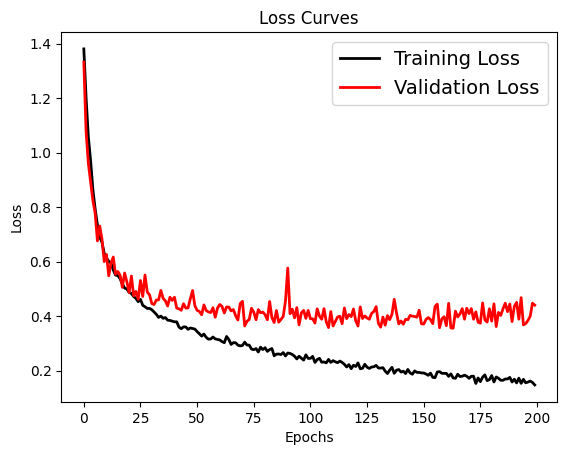

In [28]:
plt.plot(result.history['loss'], 'black', linewidth=2.0)
plt.plot(result.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14, loc='best')
plt.title('Loss Curves', fontsize=12)
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.show()

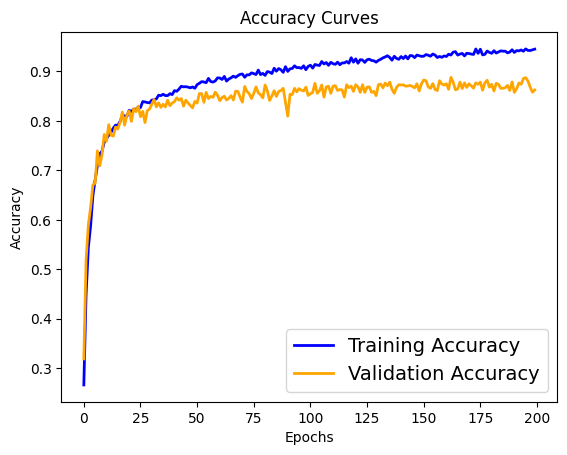

In [29]:
plt.plot(result.history['accuracy'], 'blue', linewidth=2.0)
plt.plot(result.history['val_accuracy'], 'orange', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14, loc='best')
plt.title('Accuracy Curves', fontsize=12)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.show()

In [ ]:
saving_path = ("./image-classification/mymodel/") #path penyimpanan model
tf.saved_model.save(model, saving_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with tf.io.gfile.GFile('CNN_model.tflite', 'wb') as f:
  f.write(tflite_model)